In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from surprise import Dataset, SVD, Reader, model_selection

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df1_credits = pd.read_csv("/home/valeriy/Загрузки/credits.csv.zip", compression='zip')

df2_movies = pd.read_csv("~valeriy/Загрузки/movies.csv.zip", compression='zip')

In [5]:
df1_credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [6]:
df2_movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [7]:
df2 = df1_credits.merge(df2_movies, how='outer')

In [8]:
df2.isnull().sum()

movie_id                   0
title                      0
cast                       0
crew                       0
budget                     0
genres                     0
homepage                3096
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
vote_average               0
vote_count                 0
dtype: int64

In [9]:
replacement = {'homepage': 'Unknown', 'overview': '',
               'release_date': 'Unknown', 'runtime': 'mean', 'tagline': 'Unknown'}

df2.fillna(replacement, inplace=True)

# Рекомендация по рейтингу фильма

In [10]:
df2.loc[df2.vote_count < 20]['vote_count'].shape[0] #количество фильмов, за которые проголосовало очень мало людей
                                                # Нам нужно рассчитать среднюю оценку фильма, учитывая количество голосов

667

In [67]:
m = int(df2.vote_count.quantile(0.9)) # Число голосов для фильма, чтобы включить в таблицу
C = round(df2.vote_average.mean(),1) # Средняя оценка по всем фильмам
print(m, C, sep='\n')

1842
6.1


In [12]:
q_movies = df2.copy().loc[df2['vote_count'] >= m]
q_movies.shape

(481, 23)

In [13]:
def weighted_rating(x, m=m, C=C): # Функция для расчета рейтинга
    v = x['vote_count']
    R = x['vote_average']
    return round((v/(v+m) * R) + (m/(m+v) * C),3)

In [14]:
q_movies['score'] = q_movies.apply(weighted_rating,  axis=1)

In [15]:
q_movies = q_movies.sort_values('score', ascending=False)
q_movies[['title', 'vote_average', 'vote_count', 'score']].head(10)

,title,vote_average,vote_count,score
1887,The Shawshank Redemption,8.5,8205,8.060
662,Fight Club,8.3,9413,7.940
65,The Dark Knight,8.2,12002,7.921
3237,Pulp Fiction,8.3,8428,7.905
96,Inception,8.1,13752,7.864
3342,The Godfather,8.4,5893,7.852
95,Interstellar,8.1,10867,7.810
809,Forrest Gump,8.2,7927,7.804
329,The Lord of the Rings: The Return of the King,8.1,8064,7.728
1996,The Empire Strikes Back,8.2,5879,7.699


# Рекомендация по похожему описанию(overview) фильмов

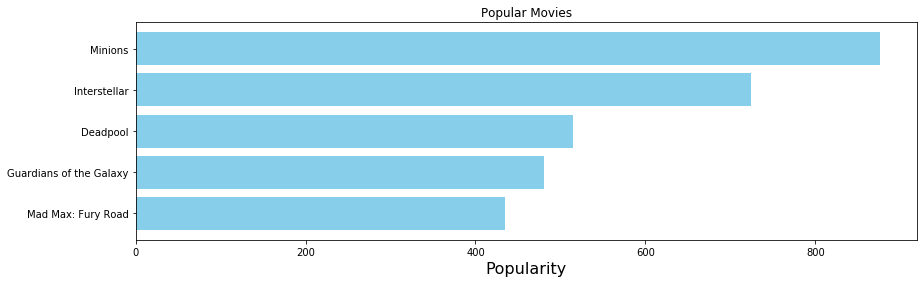

In [73]:
pop = df2.sort_values('popularity', ascending=False).head()

plt.figure(figsize=(14,4))

plt.barh(pop.title,pop.popularity, color='skyblue')
plt.gca().invert_yaxis()
plt.title('Popular Movies')
plt.xlabel('Popularity', fontsize=16);


In [17]:
tfidf = TfidfVectorizer(stop_words='english')

In [18]:
tfidf_matrix = tfidf.fit_transform(df2['overview'])
tfidf_matrix.shape

(4809, 20978)

In [19]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [20]:
indices = pd.Series(df2.index, index=df2.title).drop_duplicates()

In [21]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    sim_scores = sorted(sim_scores, key= lambda x: x[1], reverse=True)
    
    sim_scores = sim_scores[1:11]
    
    movie_indices = [i[0] for i in sim_scores]
    
    return df2.iloc[movie_indices].title

In [77]:
get_recommendations('The Avengers')

7               Avengers: Age of Ultron
3149                            Plastic
1721                            Timecop
4131                 This Thing of Ours
3316              Thank You for Smoking
3038                      The Corruptor
588     Wall Street: Money Never Sleeps
2142         Team America: World Police
1474                       The Fountain
1289                        Snowpiercer
Name: title, dtype: object

# Рекомендация по схожести, учитывая актерский состав, режиссера, жанр и ключевые слова фильма

In [23]:
features = ['cast','crew', 'keywords', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)
    


In [24]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

def get_list(x):
    if isinstance(x,list):
        names = [i['name'] for i in x]
        
        if len(names) > 3:
            names = names[:3]
        return names
    return []        

In [25]:
df2['director'] = df2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(get_list)

In [26]:
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [27]:
def clean_data(x):
    if isinstance(x,list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x,str):
            return str.lower(x.replace(" ", ""))
        else: return ""

In [28]:
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)

In [29]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

In [30]:
df2['soup'] = df2.apply(create_soup, axis=1)

In [31]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

In [32]:
cosin_sim2 = cosine_similarity(count_matrix, count_matrix)

In [89]:
indices = pd.Series(df2.index, index=df2['title'])

In [90]:
get_recommendations('The Dark Knight Rises', cosin_sim2)

65               The Dark Knight
119                Batman Begins
4644    Amidst the Devil's Wings
1199                The Prestige
3078           Romeo Is Bleeding
3331              Black November
1509                      Takers
1992                      Faster
303                     Catwoman
747               Gangster Squad
Name: title, dtype: object

# Прогнозируем оценку фильма для пользователя

In [35]:
reader = Reader()

ratings = pd.read_csv('~/Загрузки/ratings_small.csv.zip', compression='zip')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [36]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [37]:
svd = SVD()
model_selection.validation.cross_validate(svd, data=data, measures=['RMSE','MAE'], cv=5)


{'test_rmse': array([0.89529688, 0.90392007, 0.90130053, 0.88719019, 0.89951752]),
 'test_mae': array([0.68834417, 0.69613136, 0.69434966, 0.68317952, 0.6925131 ]),
 'fit_time': (9.5107421875,
  9.384256601333618,
  9.573415517807007,
  9.749310731887817,
  9.622914552688599),
 'test_time': (0.3813047409057617,
  0.33739304542541504,
  0.48528528213500977,
  0.3517577648162842,
  0.470292329788208)}

In [38]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [46]:
ratings[ratings['userId'] == 4].head(10)

,userId,movieId,rating,timestamp
147,4,10,4.0,949810645
148,4,34,5.0,949919556
149,4,112,5.0,949810582
150,4,141,5.0,949919681
151,4,153,4.0,949811346
152,4,173,3.0,949811346
153,4,185,3.0,949920047
154,4,260,5.0,949779042
155,4,289,4.0,949778802
156,4,296,5.0,949895708


In [92]:
svd.predict(4, 296,1)

Prediction(uid=4, iid=296, r_ui=1, est=4.573652110474968, details={'was_impossible': False})